#Transformer - An Example Using NanoGPT



The transformer is at the core of many famous modern AI artchitectures, notably ChatGPT, DALL-E, Sora, and Midjourney. In fact, the word **GPT** actually stands for **G**enerative **P**retrained **T**ransformer. It is a type of machine learning model that utilizes an innovative appraoch known as the self-attention mechanism. It was first published in a now famous 2017 paper entitled "Attention is All you Need" (See reference [12]). Ever since then, it has revolutionized the field and has been applied to many tasks. For instance, a transformer model can be used to solve tasks like text to voice, text to image, text generation, etc. These different tasks and scenarios all utilize the transformer model but it slightly different ways.

In this notebook, we attempt to explain the transformer architecture and self-attention in a specific scenario of large language models (LLMs) by using a small scaled LLM called NanoGPT, a model created by Andrej Karpathy. We hope that, by using a small scaled model like the NanoGPT, we can demystify much more complicated models like ChatGPT.

Note that this specific scenario utilizes a transformer that is only a decoder, which is different from the original transformer first published that utilizes both an encoder and a decoder. We will explain these concepts in more details later in this notebook.

# Transformer Architecture

Before we dive into details of the transformer achitecture of LLMs, we first present the original achitecture of encoder-decoder transformer published in the "Attention is All you Need" paper. We think it is important to show this because all other architectures are variations of this framework.

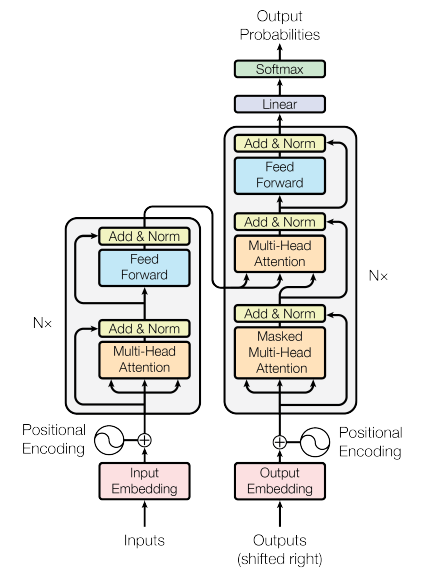

In this screenshot, the left side denotes the encoder while the right side denotes the decoder. In the original paper, the authors were trying to conduct machine translation tasks, which made both the encoder and decoder essential components. The encoder is for the original language such as English while the decoder is for the language that we want to translate into such as French. Many other architectures are also using this architecture. For example, DALLE uses an encoder-decoder transformer because it is trying to translate texts into images.

However, LLMs are not neccesarily dealing with tasks of turning texts from one language into another. As a result, they only require a decoder-like structure (as shown below).

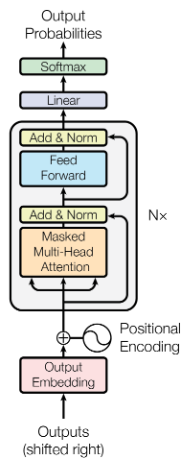

We will first give an overview of how this architeacture works:

During training, the raw text is first passed through the **Output Embedding layer** so that the machine has an initial representation of what each word means. The end result of the output embedding layer produces a set of vectors representing each word. You can think of this as a dictionary of words for the machine to keep track of.

The **Positional Encoding** calculates the position encoding for each of the words. It then adds that encoding to the original word embeddings. By adding that encoding, it ensures each word knows its relative position in the sequence. For example, the machine will be able to tell the difference between "Bob likes Alice." vs "Alice likes Bob."

Once each word knows what its relative position, they are passed through a **Masked Multi-head Attention layer** to determine how each word "attends" to every other word. For example, consider the sentence "The dog chewed the bone because it was delicious". The "it" in this case is referring to "the bone" and not "the dog". The masked multi-head attention layer allows the machine to understand how words such as "it" attends to "the bone". The attention mechanism is essential because a word may have many different connotations. To decide the meaning of each word, the machine takes context into considerations through the attention mechanism. The raw outputs from the masked multi-head attention block are combined and normalized in the **Add & Norm layer**.

Then, the **Feed Forward layer** adds complexity (non-linearlity) to the outputs to allow the machine to learn more complex patterns. Again, the outputs are processed by the **Add & Norm layer**.

The masked multi-head attention layer and feed forward layer followed by the Add & Norm layer can be considered as a single **Transformer Block**. This block will be repeated **n** times depending how complicated the text is. In our simplified version of NanoGPT, 4 transformer blocks are used. In a lot of the achitectues like ChatGPT, however, many more transformer blocks could be used. ChatGPT 3, for example, uses 96 transformer blocks.

After the final transformer block is run, the output will be passed through a **Linear layer** and **Softmax function** to generate the model's prediction of the next word given the current context. For example, let's say the context is "homework is". The model prediction could look like (("hard", 70%), ("easy", 30%)). As a result, the model will likely select "hard" as the next word creating "homework is hard".

This is an overview of what the transformer achietecture is doing. In what follows, we will give a more detailed explanation accompanied by a simplified LLM model (NanoGPT).

Note:

In this explanation we are treating tokens and words as the same thing. However, tokens and words are not equivalent. They are only treated as the same for the sake of this illustration.

# NanoGPT - A Simplified Version of ChatGPT

## Importing Necessary Libraries

In [7]:
!pip install aitk --upgrade --quiet

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import nltk
from nltk.corpus import words
import os
from aitk.utils.datasets import nanoGPT_shakespeare

## Downloading and Preparing Data

Our data is going to be all of the works of Shakespeare. The following cell downloads this data.

In [9]:
# Download the Shakespeare texts from aitk dataset
input_text = nanoGPT_shakespeare.get_dataset("shakespeare texts")

with open(input_text, 'r', encoding='utf-8') as f:
    text = f.read()

In this simplfied version of ChatGPT, we don't use words as our tokens. **Instead, we use English letters as our tokens**. For example, the tokens look like "a", "b", "c", and so on. Here is how we tokenized the text:

In [10]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

Next we split the data into a training set and a validation set:

In [11]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

Here is a snippet of what the Shakespeare training corpus looks like:

In [12]:
# read in file to a demo_text
with open("input.txt", "r") as f:
    # Read the first 50 lines
    demo_text = f.read().splitlines()[:35]

# Print the first few sentences
for sentence in demo_text:
    print(sentence)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an


# Output Embedding

The output embedding layer or just embedding layer essentially creates an embedding of the training data by putting each token (in our case each letter) as a vector in space. By representing each token as a vector in space, the machine can form an understanding of the context in which the letters typically occur in the training data. You can think of the embedding layer as developing a dictionary for the machine to keep track of.

This is just an overview. To learn more about this, you can check out our notebook on word embeddings:
[AITK Word Embedding Notebook](https://colab.research.google.com/drive/1aW9e3GVZQWeC0Sr5qcGY9Qo3K30MTHG6)

Alternatively, you can access it from colab by clicking this buttom:


<a href="https://colab.research.google.com/drive/1aW9e3GVZQWeC0Sr5qcGY9Qo3K30MTHG6" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook, we loaded a word embedding table from pytorch to serve as the output embedding layer for simplicity:
```python
  tok_emb = self.token_embedding_table(idx)
```

# Positional Encoding

Like what was mentioned before, Positional Encoding evaluates the position encoding of each token in a sequence and adds that encoding to the original embeddings so that each token knows where they are in the sequence.

There are multiple ways of how positional encoding can be calculated.

**(1) Neural Net based absolute positional encoding:**

This encoding method basically uses a neural network to learn the positional encoding vectors for each word in a sequence. For example, consider the sentence "NanoGPT likes to pretend it is ChatGPT". Each word has a specific order in the position, let's say:

"NanoGPT" -> 11, "likes" -> 12, "to" -> 13, "pretend" -> 14, "it" -> 15, "is" -> 16, "ChatGPT" -> 17.

A neural network will assign each word a positional encoding vector depending what order the word has.

However, this method could be very time consuming because a neural net needs to decide the position vectors for each word ahead of time.

**(2) Frequency based absolute positional encoding:**

This encoding method utilizes frequency function to calculate the position vectors for each word, which is less time consuming than using the neural network. There are many ways to specify the frequency function. For example, from the paper, a sine function is used for the even indices while a cosine function is used for the odd indices.

For the even indices, positional encoding vector is calculated this way:

\begin{align}
 PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{align}

For the odd indices, it is calculated this way:

\begin{align}
 PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{align}

Consider again the sentence "Little NanoGPT likes ChatGPT". Each word has a specific order in the position, let's say:

"Little" -> 0, "NanoGPT" -> 1, "likes" -> 2, "ChatGPT" -> 3.

Each of the positions  will be passed through the frequency functions specified above to generate the corresponding positional embedding vectors.

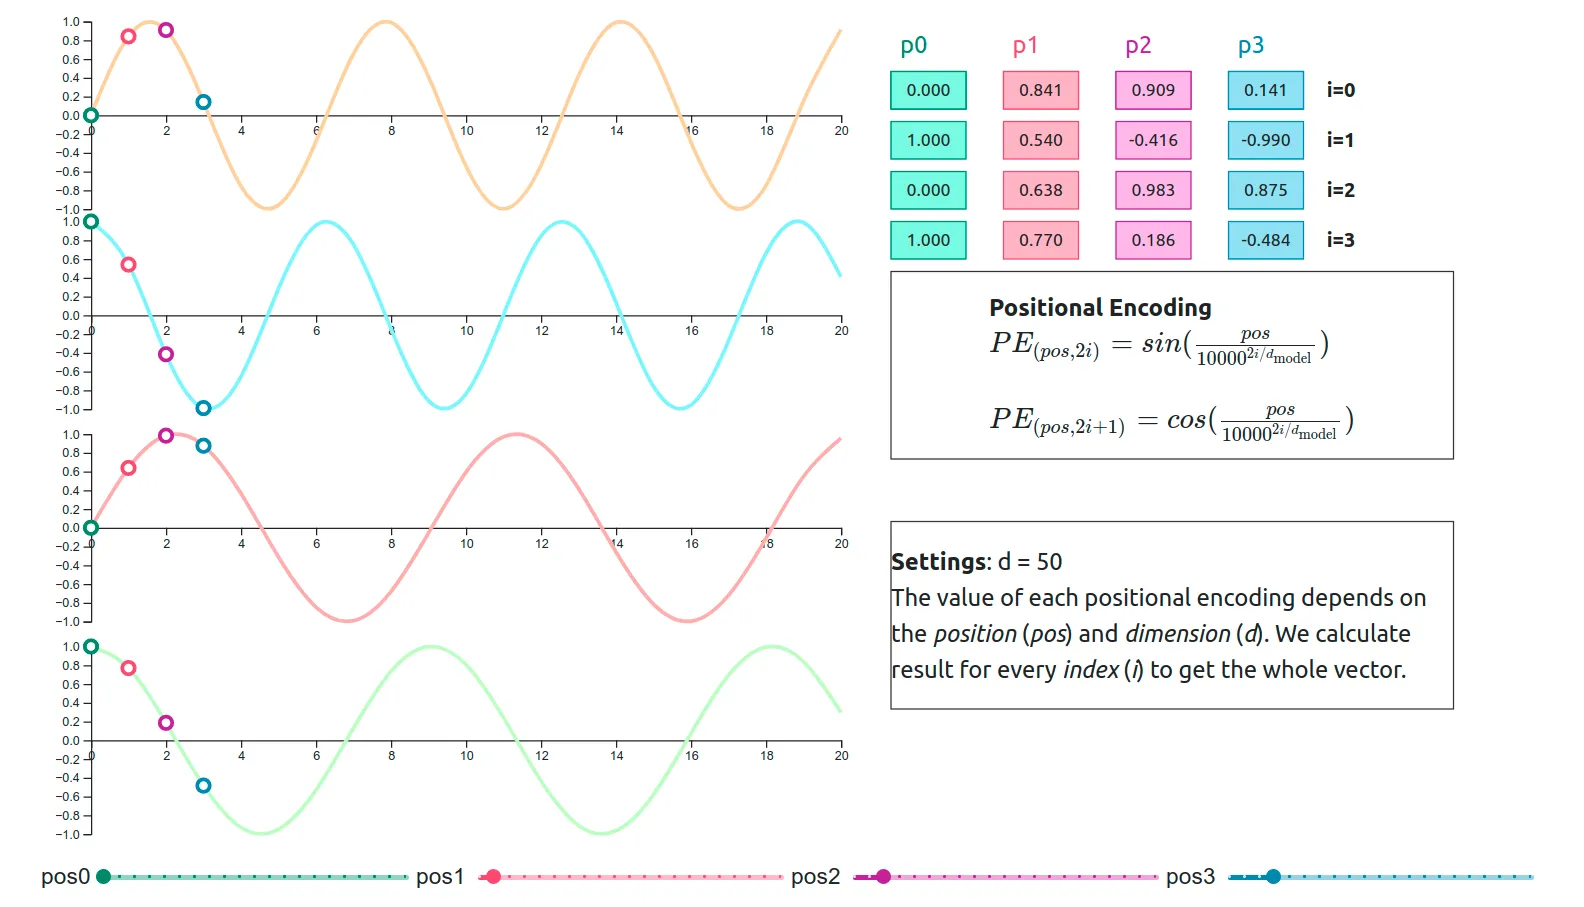

In this screenshot, you can see how position 0 ("Little") has generated a positional encoding of dimention 4, namely,
\begin{pmatrix} 0 \\ 1 \\ 0 \\ 1 \end{pmatrix}

Correspondingly, position 1 ("NanoGPT") will have positional encoding,
\begin{pmatrix} 0.841 \\ 0.540 \\ 0.638 \\ 0.770 \end{pmatrix}

position 2 ("likes") has,
\begin{pmatrix} 0.909 \\ -0.416 \\ 0.983 \\ 0.186 \end{pmatrix}

position 3 ("ChatGPT") has,
\begin{pmatrix} 0.141 \\ -0.990 \\ 0.875 \\ -0.484 \end{pmatrix}

Once the positional encodings are calculated using the formula, they will be added to the embedding of their corresponding word. Let's say the embedding of "Little" is,
\begin{pmatrix} 0.1 \\ -0.1\\ 0.1 \\ -0.1 \end{pmatrix}

The final embedding for "Little" will be,
\begin{pmatrix} 0.1 \\ 0.9\\ 0.1 \\ 0.9 \end{pmatrix}

Generally, **frequency based positional encoding** is preferred becuase it encodes the positions very well without the need to use a neural network to learn the positional encoding vector.

In this notebook, we are loading a learned positional embedding from pytorch for simplicity:
```python
  self.position_embedding_table = nn.Embedding(block_size, n_embd)
```
Adding positional encoding to the embedding table:
```python
# idx and targets are both (B,T) tensor of integers
  tok_emb = self.token_embedding_table(idx) # (B,T,C)
  pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
  x = tok_emb + pos_emb # (B,T,C)
```

These code will be run later when we initialize the transformer.

# The Attention Mechanism

## Scaled Dot Product Attention

In the "Attention is All you Need" paper, attention is calculated by first calculating a query, a key, and a value for the tokens in a sequence. Query, key, and value are calculated by applying learned linear transformations to the word embeddings of the tokens. For example, let's say the query is Q and the word embedding is W_emb. We will run the neural network to find a learned linear transformation T_q.
Then, the query will be calculated like this:
\begin{align}
Q = W_{emb}T_q
\end{align}

After finding what the query, key, and value are. Attention can be calculated using this formula:

\begin{align}
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
\end{align}
where:
- \( Q \) is the query matrix.
- \( K \) is the key matrix.
- \( V \) is the value matrix.
- \( d_k \) is the dimension of the key/query vectors.

The **intuition** behind this is that the query denotes some words that are trying to find words that it can attend to while the key serves as potential answers to the words that are doing the query. By calculating $QK^T$, we are essentially calculating the dot products between the query and key. If a query has found a key, then it indicates that a query "attends" to a key. As a result, the dot product will show a bigger value. Otherwise, it will show a lower value.

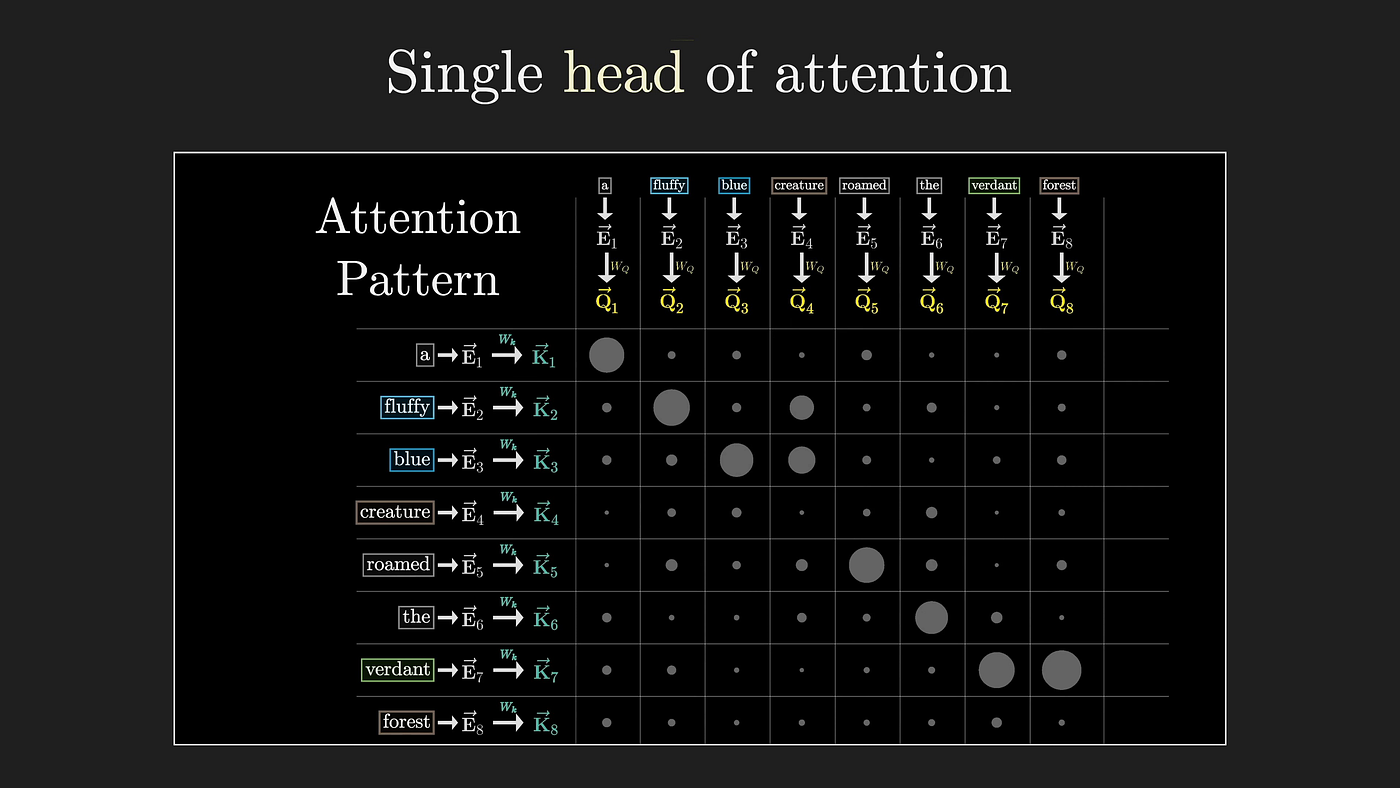

Let us explain this further using an example ("a fluffy blue creature roamed the verdant forest"). In this picture, key and query are linear transformations of the original words. The y-coordinate donotes the keys while the x-coordinate denotes the querys. Note how both the querys and keys are generated by applying a linear transformation (W_Q or W_k) on the word embeddings (E_i). For each possible pair of words a gray circles is depicted in this coordinate system. Bigger circles indicate that the dot product between the corresponding key and query evaluates to a bigger value. If the dot product evaluates to a bigger value, we say that a query "attends" to that key.

For the purpose of this example, let's say a noun is trying to find if there are adjectives before it so that it can better understand what it means in a certain context. In this case, the nouns are the querys while the adjectives are the keys. For example, "creature" and "forest" are two nouns in the sentence: "a fluffy blue creature roamed the verdant forest". In this matrix multiplication, we can see that "creature" has connections with "fluffy" and "blue" while "forest" has connections with "verdant" since the corresponding circles are quite big. By forming connections with the adjectives, the machine is better able to understand the meanings of those nouns.

This is just an example of how the machine is able to better understand the meaning of words by calculating the attention pattern (matching the querys with the keys).

Note:

In this example, for simplicity, we assume that the noun will try to attend to the adjectives to identify its meanings. However, this might not neccesarily be the case in the actual practice.

The NanoGPT actually has a very different attention mechanism since it utilizes English letters as its tokens. For example, consider the word "museum". There are two "u"s in this sentence. The first "u" will be able to tell its "meaning" by realizing "m" comes before it. The second "u" sees "m", "u", "s" and "e" come before it and realize a different "meaning". These "meanings" or attention patterns are calculated in a similar way as the previous example. By identifying these "meanings", the machine will be able to better spell words or even write sentences in the future by realizing that "u" is likely to come after "m" while another "u" is likely to come after "muse".

This example is from 3blue1brown's youtube video, which have great explainations on transformer. The video has been linked in the references section (see [1]).

In [13]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

## Masked multi-head Attention

Let's first explain what Multi-head attention is. Multi-head attention is essentially just several single scaled dot product attention heads operating in parallel. The following figure gives a visualization of how the scaled dot product attention can parallelized.


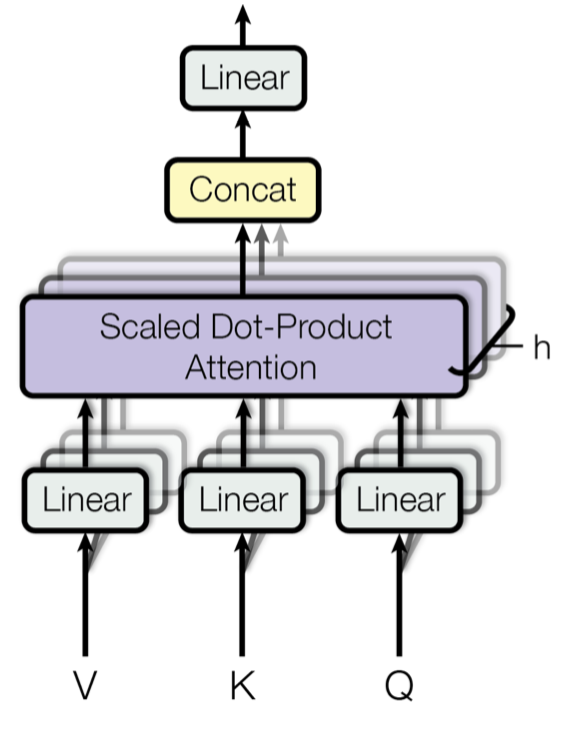

In this figure, we can see how the first single scaled dot product attention head is put in deep color while the subsequent heads are put in lighter and lighter color.

Each single scaled dot product attention head will have a reduced dimension of the overall model dimension. For example, if the model dimension or world embedding dimension is 512. Let's say we have 8 heads in parallel. We will then deal with 512/8 = 64 dimension per single scaled dot product attention head.

By doing this, the intuition is that we are allowing each head to have a focus when they are attending to different parts of the text. Each head is attending the text from their own subspace at different posisitons of the text.

If we only have a single scaled dot product attention head, the effect of attention will be averaged across texts and less substantial connections will be formed across different texts.

A masked multi-head attention is a multi-head attention where the full context is masked. This can be achieved by making the matrices used for calculating the attention to be triangular.

The intuition behind this is that during training, we don't want the transformer to see the full context. We only want the transformer to see the previous words when making the predictions. If the full context is shown, the transformer will have seen the context already.

For example, if we have a sentence "NanoGPT pretends to be ChatGPT". If the machine is trying to predict the next word when given the context "NanoGPT prentends to be", we don't want to include the last word ("ChatGPT") in the context because we would have given away the answer.

In [14]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

# Feed forward Layer

The feed forward layer is only a regular layer neural network that was used in the traditional machine learning. It is added to add complexity to the system so that it is able to learn more complex patterns.

In [15]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# Transformer Block

Once we have defined all the essentila parts of the transformer, we are ready to group them together to make a transformer block. It can be repeated n times depending how large our model is.

In [16]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# Model Definition of NanoGPT

Now, we are ready to define our NanoGPT. It will now take the full form as the architecture that we have shown earlier. We will fist add a word embedding table for the corpus. Second, a positional encoding will be added on top of that. Next, n transformer blocks will be added. Finally, a linear layer and softmax function are applied to generate the probabilities.

In [17]:
class NanoGPTLanguageModel(nn.Module):
    """ super simple NanoGPTLanguageModel """

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

Now that we have defined our model, we are ready to proceed to the training step.

# Training the NanoGPT

## Tunable Parameters for training

In [18]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

## Seed Initialization

In [19]:
torch.manual_seed(1337)

## Essential Parts for Training a Neural Network

Defining get_batch and loss function:

In [20]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Creating an Instance of the NanoGPT Model

In [21]:
model = NanoGPTLanguageModel()
m = model.to(device)

Congratulations! You have just created your own NanoGPT. Let's see how it is doing with generating words.

In [22]:
# generate from the model, initialize the context to be empty space
context = torch.zeros((1, 1), dtype=torch.long, device=device)
output = decode(m.generate(context, max_new_tokens=2000)[0].tolist())
print(output)


lRHoOSbJDkfnqOsG?ySVlLNAA'jW3I-uNVbqwsjAbjVOAAIeHkhqUN3qUUsHw-&DbFch:t..JPAWVU!nAtyvUYAFWCd!ngOEo.$A,!NJIyVrrU&bO,J
D33xiyDecfNCKoLj?rcX?CeTUNUKuneG-UUo&pDthqGiCDuUpn?O
ppDzx'p&pRczecVGAzqsnR'XuHJxngBc$onocJuElncX:,CEWw-?bG-AtPZp;bCioC
yCm$yGAicrq3xz:d3iQeV&NH.qlS'HDetj-LR;;!k-pbIo$Vczfd!Dw!$XeNNCo-cADCQ-jH.Jgwzt.HktLfDJ,PGNAFpKNP;mtg.KRkXvAYDcAkWTwOhquYcAzIo!,V;hTOZVKZJDhoAi;ShqJfEyZpbSoh!U:,v;mJ?HiogMaRoC,s!RSUoUwuo?ibte-&?KgmGz:CXe?JVaU&ROjc&.Y
LU
iawJesdMBO!dGedMp 3!bC$foTJno!qMDFZjUyruCOoeA!zlneVcPpXhggH3gGIovd;VDXz?UJTRKK!NLe$Yzl,By-Q$,Vi-&jy.Egg?R,oPRVutfVKI,m-oh'. RTebSK!FT-WoE'cUSihD!edzLoJicyX;OyFcJs.tLENwNw?dlL.v?nxrb?RZvLwuUf$CUgwBipXogo.eXeR.3KUoO!h!R..U!LeINvQ'KUoL.Gz'JCqP&UFsCgothK3p:DXK:fWApz-zDv,NEjJEu$f wjo,Z p3DoA,pRLIwkBczhxEsTZJvwJw:uNUTJ!De,Ocnxm.&;ADQbhXfLSp:eztWDKcUvjvtQoOoy?-?s$d?JciyquJPN,cE;fyKh,nhyN$&LNUU$!Jc! sVek&UL;ykYTpdiWObbwSu,tWK,pSUZoKbcp?X,NZOcoHJVpVL&mRQF$pZFn,aOcdoSQ3-KfdFo,DMf IfYUJzot.:Am!hlhNbqUqRWhvGzJ-q-L.p?SNlx$pFUQ!HJPz:-bhn&Ie!eLTNcbocAwn

This doesn't look like Shakespeare at all.

Let's analyze this with a simple word counting function.

In [23]:
# Ensure the 'words' corpus is downloaded
nltk.download('words')

def word_counter(input):
  output_words = input.split()

  # Get the list of valid English words
  english_words = set(words.words())

  # Count the number of correctly spelled words
  correctly_spelled_words = [word for word in output_words if word.lower() in english_words]
  correct_count = len(correctly_spelled_words)
  total_count = len(output_words)

  # Print the results
  print(f"Total words: {total_count}")
  print(f"Correctly spelled words: {correct_count}")
  print(f"Percentage of correctly spelled words: {correct_count / total_count * 100:.2f}%")

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [24]:
word_counter(output)

Total words: 35
Correctly spelled words: 0
Percentage of correctly spelled words: 0.00%


After runing the word counter function, you will see a close to 0% correctness. This is because we haven't trained the model yet! Let's start training!

Note:

when we are generating the words, we specify the context to be empty space. The model is going to predict the words that might come next based on the context and its training. The context could actualy be changed to anything the user wants. This is similar to how we ask ChatGPT questions. The question that we give ChatGPT can be considered as the context.

## Training the Model

Our model is training for 1000 epochs and see how it performs. This proccess should take approximatly 2 mins.

In [25]:
# defining a global variable to keep track of the training epochs
current_epochs = 0

def training(training_epochs):
  # print the number of parameters in the model
  print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

  # create a PyTorch optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

  # declaring current_epochs as global so that it can be accessed and modified
  global current_epochs

  # calculating max_iters
  max_iters = training_epochs + current_epochs

  for iter in range(current_epochs, max_iters):

      # every once in a while evaluate the loss on train and val sets
      if iter % eval_interval == 0 or iter == max_iters - 1:
          losses = estimate_loss()
          print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

      # sample a batch of data
      xb, yb = get_batch('train')

      # evaluate the loss
      logits, loss = model(xb, yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

  current_epochs += training_epochs

In [26]:
# trains the model for 1000 epochs
training(1000)

0.209729 M parameters
step 0: train loss 4.4077, val loss 4.4024
step 100: train loss 2.6498, val loss 2.6510
step 200: train loss 2.4997, val loss 2.4976
step 300: train loss 2.4218, val loss 2.4229
step 400: train loss 2.3468, val loss 2.3601
step 500: train loss 2.2951, val loss 2.3150
step 600: train loss 2.2490, val loss 2.2617
step 700: train loss 2.2046, val loss 2.2161
step 800: train loss 2.1576, val loss 2.1919
step 900: train loss 2.1368, val loss 2.1679
step 999: train loss 2.0971, val loss 2.1313


Let' see how it performs now!

In [27]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
output = decode(m.generate(context, max_new_tokens=2000)[0].tolist())
print(output)


thes oree pince to magh'llfat, hep wir tere if him tis ang,
oun netoor brronged I's we merelftand youghy.

As bat your ofen the hearshint that.

ORD VORKEES:
In meince:
Ay knot'll and fory'e barot wenche.'d prewst henvearbpoore
thefffor se tenfureor on and half
Telfors; Tecoures yould sof, meak breirs kere
ner, to plomers astrermern ingies.

Thur comend your becel willsAn you.

MELRUKIV:
BKlfaarl;
Frly wars my dimiven:
Thathe moh ear were so no avee with mranysur,
Whe buand poorer and Yor wour deing vlave uss,
Witll filll heacht I halfare etcee,
Vail fak, ey beat muon pines rimear yore Hint, her his yest then too the bealfathan ming andppard.

YRORTYSTher hencens fally to furt histachis my aid ware:
Whelt:
That nashelline, heard nope you hir he woll haver
te ewher wa efier engrart geast 
Prighponey Oor and beeaten.o, theren pentlyseien prent bry gin treair?
Arled my mey unwerore and wetsill,;
Fill sheatlen, ill sirneais af fore.
Gre! oun deealt nome tanry, what are dive ase shelfour i

This looks much more like Shakespeare now as the model has understood the conversational style of the play from Shakespere. However, it looks like the model hasn't yet grasped the correct spelling of most words.

In [28]:
word_counter(output)

Total words: 329
Correctly spelled words: 119
Percentage of correctly spelled words: 36.17%


The word count function should indicate that NanoGPT spell the words correctly for around 35% of the time.

Let's train the model for another 2000 epochs and see how it performs. This should take for about 3 mins.

In [29]:
# trains the model for 2000 epochs
training(2000)

0.209729 M parameters
step 1000: train loss 2.0969, val loss 2.1305
step 1100: train loss 2.0652, val loss 2.1011
step 1200: train loss 2.0347, val loss 2.0751
step 1300: train loss 2.0111, val loss 2.0610
step 1400: train loss 1.9854, val loss 2.0551
step 1500: train loss 1.9750, val loss 2.0334
step 1600: train loss 1.9556, val loss 2.0307
step 1700: train loss 1.9424, val loss 2.0154
step 1800: train loss 1.9244, val loss 2.0079
step 1900: train loss 1.9080, val loss 2.0062
step 2000: train loss 1.8915, val loss 1.9808
step 2100: train loss 1.8896, val loss 1.9805
step 2200: train loss 1.8673, val loss 1.9569
step 2300: train loss 1.8571, val loss 1.9629
step 2400: train loss 1.8433, val loss 1.9446
step 2500: train loss 1.8377, val loss 1.9514
step 2600: train loss 1.8214, val loss 1.9298
step 2700: train loss 1.8177, val loss 1.9283
step 2800: train loss 1.8100, val loss 1.9293
step 2900: train loss 1.8067, val loss 1.9337
step 2999: train loss 1.7884, val loss 1.9294


Start generating outputs from NanoGPT:

In [30]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
output = decode(m.generate(context, max_new_tokens=2000)[0].tolist())
print(output)



First, and so
To chapee leaking: and by beson, and with a usher:
Of me wach, Pold meat heaven rignand
As lead thiss chepom 't you! as smeliesmed.
The cands, and but his lay
Their haw hathem, of let thee hathere slaped;
To eaurse Sawn the some lird to teass whads lesat's to choursed annigen:
The mane by grave not nobt that?

ABELINA:
I hape time that; where may work?
And brisst make shee haminim the lasching out-rath, hoursellireshem you.

CORICEN'ENIO:
Least:
My subce, for this him.

TULIies make comespirit our kpoys yet ent Henem greasign tabe agentage:
And to which, amand, how untle that he some that mistre knimples wong.
He hered as this light wing, my with thinkle in, for hearse dide a knight,
Pring was while brack dings and watherfulse whriek!

LARD IV:
Hou way, on must lord: why here, for is my baviss:
Bot, he wantle, and me come. 
I while hold is and anger, dier fing chisg?

FRYORIS:
Let not cown the he, but a in dothing Lords theugh thou manigh.

AUFIDIDIUS:
Hath she o'so-no 

The model is able to grasp some of the spelling, but it is still not perfect. In order to get better results you would need to train the model for more epochs and with larger batch and block sizes using better hardware.

In [31]:
word_counter(output)

Total words: 365
Correctly spelled words: 198
Percentage of correctly spelled words: 54.25%


With this additional training, NanoGPT should now be able to  spell the words right for about 50% of the time.

# Loading Pre-trained Model

Here is a pre-trained model that we have trained using better hardware and for a much longer time. Let's load it and see how its performance compares to the model that you trained from scratch. This may take about a minute to load.

In [32]:
# Download the shakespeare texts from aitk dataset
saved_model_path = nanoGPT_shakespeare.get_dataset("saved model")

# Loading model
saved_model = torch.load(saved_model_path, map_location=device)
m = saved_model.to(device)

Start generating outputs from NanoGPT:

In [33]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
output = decode(m.generate(context, max_new_tokens=2000)[0].tolist())
print(output)



QUEEN ELIZABETH:
In bendefallisk, sweet woman alreast
Is friend undon't: think you will do me well.

PRINCE EDWARD:
Kind a time Aus Plantagenet.

RIVERS:
But is a toward Stanlemo, peace, I birth you.
Worthy will we but, my brother Montague,
Such fire ever years swe twill be:
Here's bad my bester made the man again:
Poor sheeps of Antiates for my boy,
And conceive grief with ched me aloud feeling?
Go to: the bark is valour with us.

ANGELO:
Fear not to thank you a tale will at you understand;
Which eight to full sweak soul triumphant;
That in thegres of my faint, right!
The hollow was our worth place, Clarence to get Herbore,
Help Tybalt, good Mercure of Gaunt:
Not you talk a thrasty more,
For time thee, your advised fathers.

BUCKINGHAM:
And I, my lord.

GLOUCESTER:

CLARENCE:
Faith, one peril offence!
Let'suaght them brought by joy of this youth,
I would not but I had bond but a languager.

GLOUCESTER:
I am a bowdy thus as we are:
'tis latter, the way comparel:' take me so my hand t

In [34]:
word_counter(output)

Total words: 367
Correctly spelled words: 242
Percentage of correctly spelled words: 65.94%


NanoGPT's spelling correctness has likely improved to at least 65% or higher. This demonstrates that the model has continued to improve with additional training time.

# Fine tuning

Lastly, we want to talk about fine tuning. You may be wondering why NanoGPT cannot answer questions from us as ChatGPT does. The reason for this is that ChatGPT has gone through a fine tuning process so that it has learned how to interact with humans in a conversational manner. The finetuning is done using a combination of supervised learning and reinforcement learning. Without finetuning, a LLM based transformer will only be a document completer. It is only trying to predict the next token based on what the context that it is given. We call this type of transformer a pre-trained transformer. Transformer like ChatGPT, on the other hand, are called fine-tuned transformers. So, the NanoGPT that we just built is only a pre-trained transformer.

# References

[1] 3Blue1Brown. Attention in Transformers, Visually Explained | Chapter 6, Deep Learning. 2024. YouTube, https://www.youtube.com/watch?v=eMlx5fFNoYc.

[2] 3Blue1Brown. But What Is a GPT?  Visual Intro to Transformers | Chapter 5, Deep Learning. 2024. YouTube, https://www.youtube.com/watch?v=wjZofJX0v4M.

[3] Andrej Karpathy. [1hr Talk] Intro to Large Language Models. 2023. YouTube, https://www.youtube.com/watch?v=zjkBMFhNj_g.

[4] Andrej Karpathy. Let’s Build GPT: From Scratch, in Code, Spelled Out. 2023. YouTube, https://www.youtube.com/watch?v=kCc8FmEb1nY.

[5] Erdem (burnpiro), Kemal. “Understanding Positional Encoding in Transformers.” Medium, 13 May 2021, https://towardsdatascience.com/understanding-positional-encoding-in-transformers-dc6bafc021ab.

[6] Gupta, Yashu. “Chat GPT and GPT 3 Detailed Architecture Study-Deep NLP Horse.” Nerd For Tech, 16 Mar. 2023, https://medium.com/nerd-for-tech/gpt3-and-chat-gpt-detailed-architecture-study-deep-nlp-horse-db3af9de8a5d.


[7] Karpathy, Andrej. “nanoGPT.” Github, https://github.com/karpathy/nanoGPT. Accessed 17 July 2024.


[8] Karpathy, Andrej. “Ng-Video-Lecture/Gpt.Py at Master · Karpathy/Ng-Video-Lecture.” GitHub, https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py. Accessed 17 July 2024.

[9] “Let’s Read: Transformer Models, Part 2.” A Trivial Knot, 7 Jan. 2024, https://freethoughtblogs.com/atrivialknot/2024/01/07/lets-read-transformer-models-part-2/.

[10] Stanford Online. Stanford XCS224U: NLU I Contextual Word Representations, Part 3: Positional Encoding I Spring 2023. 2023. YouTube, https://www.youtube.com/watch?v=JERXX2Byr90.

[11] StatQuest with Josh Starmer. Transformer Neural Networks, ChatGPT’s Foundation, Clearly Explained!!! 2023. YouTube, https://www.youtube.com/watch?v=zxQyTK8quyY.

[12] Vaswani, Ashish, et al. Attention Is All You Need. arXiv:1706.03762, arXiv, 1 Aug. 2023. arXiv.org, https://doi.org/10.48550/arXiv.1706.03762.


## Note

This is a modifications and adaptation on Andrej Karpathy's nanoGPT, here is his github repos again:

https://github.com/karpathy/nanoGPT

https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py


MIT License